In [ ]:
#!/usr/bin/env python3
# train.py

import os
import json
import random
import numpy as np
import pandas as pd
import joblib
import time 

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)
from imblearn.combine import SMOTEENN
from codecarbon import EmissionsTracker


# 1️⃣  Config & reproducibility
SEED       = 42
DATA_PATH  = '/Users/kiransaud/Desktop/XAI-SHAP/dataset/dataset.xlsx'
SHEET_NAME = "method"
OUT_DIR    = "models"

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# create output directory if needed
os.makedirs(OUT_DIR, exist_ok=True)

# 2️⃣  Load & clean
df = (
    pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
      .drop(["Project","Hash","LongName","Number of Bugs"], axis=1)
      .drop_duplicates()
)
assert set(df["Buggy"]) <= {0,1}, "Target 'Buggy' must be 0/1."
X = df.drop("Buggy", axis=1)
y = df["Buggy"]

# 3️⃣  Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)


# 5️⃣ Scale to [0,1] (helps stacking & later SHAP)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X.columns)

# 6️⃣ Resample with SMOTEENN
smoteenn = SMOTEENN(random_state=SEED)
t0 = time.time()
X_train_bal, y_train_bal = smoteenn.fit_resample(X_train_scaled, y_train)
print("Resampled:", dict(zip(*np.unique(y_train_bal, return_counts=True))))
print(f"SMOTEENN time: {time.time()-t0:.1f}s")



param_dist = {
    'n_estimators':      [1000],
    'max_depth':         [100, None],
    'min_samples_split': [2],
    'min_samples_leaf':  [1],
    'max_features':      ['sqrt',4],
    'class_weight':      [None, 'balanced', {0:1}],
    'criterion':        ['gini', 'entropy'],
    'bootstrap':        [True, False],

}
tracker = EmissionsTracker(
    project_name="RF_Baseline", output_dir=".", save_to_file=True
)
tracker.start()

search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=SEED, n_jobs=-1),
    param_distributions=param_dist,

    scoring = ["recall","f1", "precision", "roc_auc",],
    refit = "recall", #to catch more real bugs if we want balanced approach meaining balance of recall and precision then we can use refit = "f1".
    n_iter=30,
    cv=5, 
    verbose=4, 
    random_state=SEED, 
    n_jobs=-1
)

search.fit(X_train_bal, y_train_bal)

print("🏅 Best params:", search.best_params_)
print("🏅 Best CV PR-AUC:", search.best_score_)

# 7️⃣  Final fit with emissions tracking
best_rf = RandomForestClassifier(**search.best_params_, random_state=SEED, n_jobs=-1)

best_rf.fit(X_train_bal, y_train_bal)
emissions = tracker.stop() # Stop tracking after all training is done

print(f"🌱 CO₂e emissions (kg): {emissions:.4f}")
del tracker

# 8️⃣  Evaluate
y_prob = best_rf.predict_proba(X_test_scaled)[:,1]
y_pred = (y_prob >= 0.5).astype(int)
print("\n📊 Test Classification Report")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR  AUC:", average_precision_score(y_test, y_prob))

# 9️⃣  Find optimal threshold for max-F1
prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1 = 2*prec*rec/(prec+rec)
i_best = np.nanargmax(f1)
opt_thresh = float(thr[i_best])
print(f"\n🔎 Optimal threshold: {opt_thresh:.3f}  (F1={f1[i_best]:.3f})")

# 🔟  Serialize artifacts
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.pkl"))
joblib.dump(best_rf, os.path.join(OUT_DIR, "rf_baseline.pkl"))
with open(os.path.join(OUT_DIR, "threshold.json"), "w") as fp:
    json.dump({"threshold": opt_thresh}, fp)

print(f"\n✅ Artifacts saved to '{OUT_DIR}/': scaler.pkl, rf_baseline.pkl, threshold.json")


[codecarbon WARNING @ 09:36:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 09:36:27] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 09:36:27] [setup] RAM Tracking...
[codecarbon INFO @ 09:36:27] [setup] CPU Tracking...


Resampled: {np.int64(0): np.int64(12490), np.int64(1): np.int64(21194)}
SMOTEENN time: 7.3s


[codecarbon WARNING @ 09:36:27] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon WARNING @ 09:36:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 09:36:28] CPU Model on constant consumption mode: Apple M2
[codecarbon WARNING @ 09:36:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:36:28] [setup] GPU Tracking...
[codecarbon INFO @ 09:36:28] No GPU found.
[codecarbon INFO @ 09:36:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 09:36:28] >>> Tracker's metadata:
[codecarbon INFO @ 09:36:28]   Platform system: macOS-15.3-arm64-arm-64bit
[codecarbon INFO @ 09:36:28]   Python version: 3.10

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

[codecarbon INFO @ 09:36:45] Energy consumed for RAM : 0.000013 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 09:36:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:36:45] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 09:36:45] 0.000190 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:37:00] Energy consumed for RAM : 0.000025 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 09:37:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:37:00] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 09:37:00] 0.000380 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:37:15] Energy consumed for RAM : 0.000037 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 09:37:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:37:15] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 09:37:15] 0.000569 kWh of 

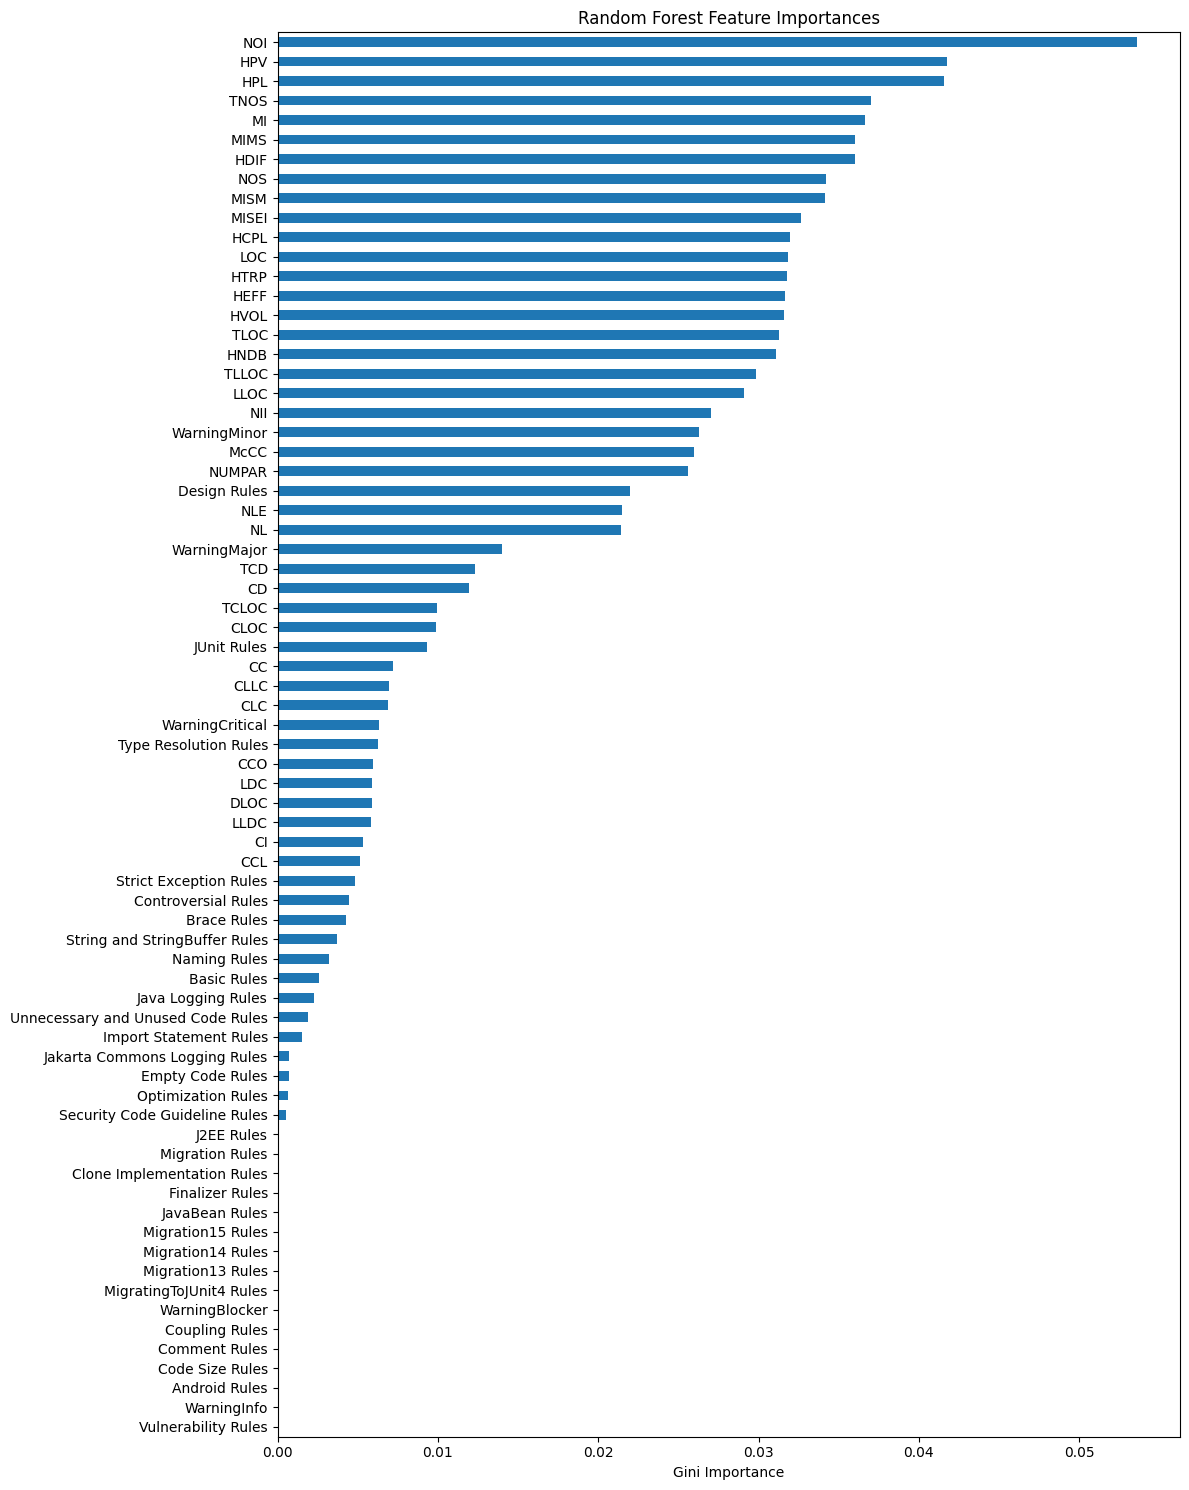

In [2]:
import matplotlib.pyplot as plt
import pandas as pd


# 1) Re-wrap X_train_bal (a NumPy array) into a DataFrame so we keep feature names
X_train_bal_df = pd.DataFrame(X_train_bal, columns=X_train_scaled.columns)

# 2) Build a Series of importances indexed by feature name
importances = pd.Series(
    best_rf.feature_importances_,
    index=X_train_bal_df.columns
)

# 3) Plot
plt.figure(figsize=(12, 15))
importances.sort_values(ascending=True).plot.barh()
plt.xlabel("Gini Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


📋 Classification Report
              precision    recall  f1-score   support

   Not Buggy       0.73      0.51      0.60     10909
       Buggy       0.37      0.61      0.46      5216

    accuracy                           0.54     16125
   macro avg       0.55      0.56      0.53     16125
weighted avg       0.61      0.54      0.55     16125



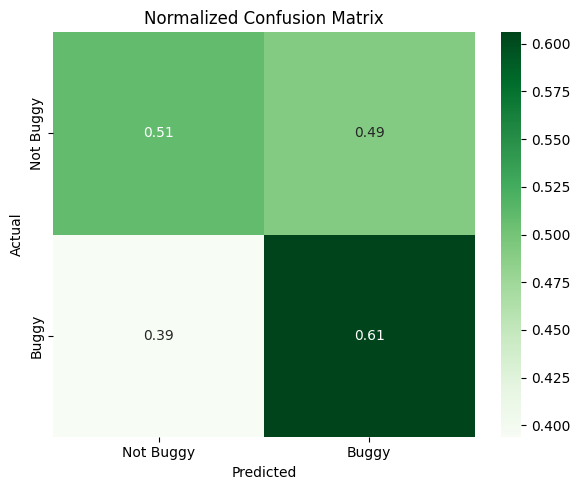

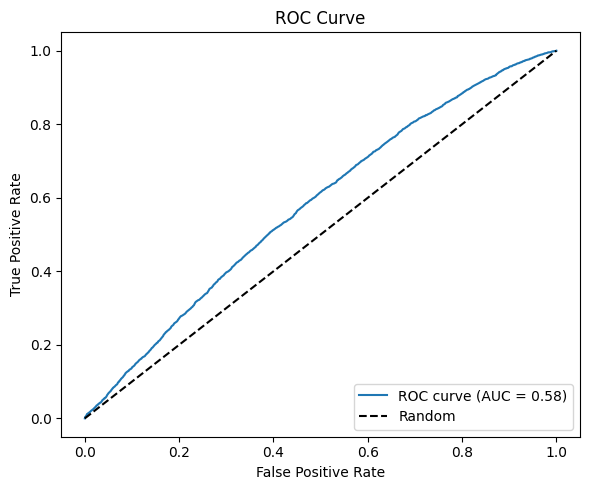

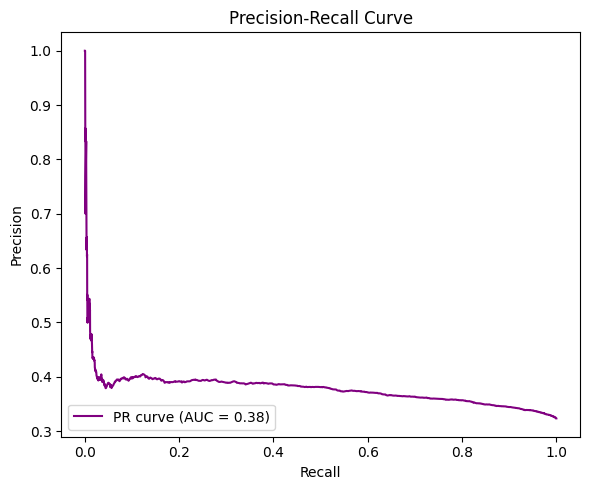

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report
)

def evaluate_and_plot(model, X_test, y_test, threshold=0.5):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    print("\n📋 Classification Report")
    print(classification_report(y_test, y_pred, target_names=["Not Buggy", "Buggy"]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, cmap="Greens", fmt=".2f", xticklabels=["Not Buggy", "Buggy"], yticklabels=["Not Buggy", "Buggy"])
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="purple", label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

# 👉 Call this after model training
evaluate_and_plot(best_rf, X_test_scaled, y_test, threshold=0.499)


In [ ]:

import ace_tools_open as tools

# Create a summary table with selected columns and total energy
summary_cols = [
    "timestamp","project_name","run_id","experiment_id","duration","country_name","region",
    "emissions", "emissions_rate", "cpu_power", "gpu_power", "ram_power",
    "cpu_energy", "gpu_energy", "ram_energy"
]

summary_df = df[summary_cols].copy()
summary_df["Total Energy (kWh)"] = df["energy_consumed"]

tools.display_dataframe_to_user(name="CodeCarbon Energy Summary", dataframe=summary_df.round(6))


CodeCarbon Energy Summary


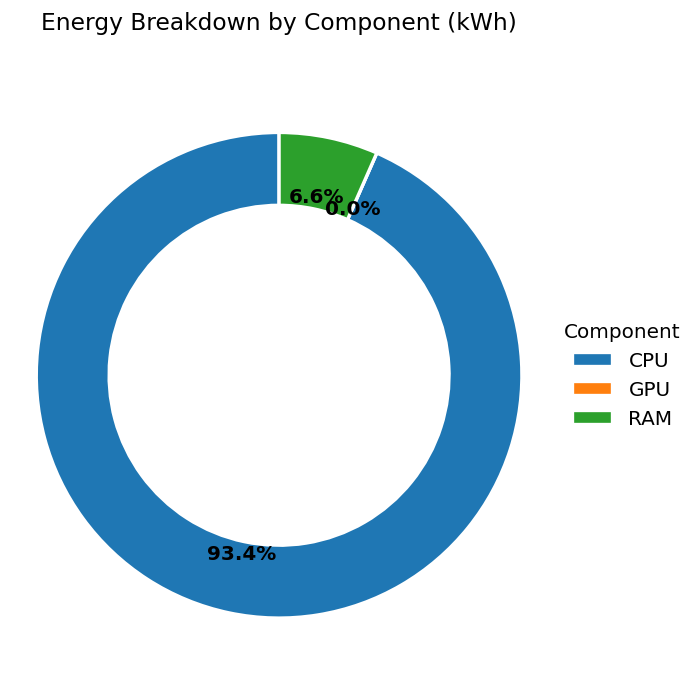

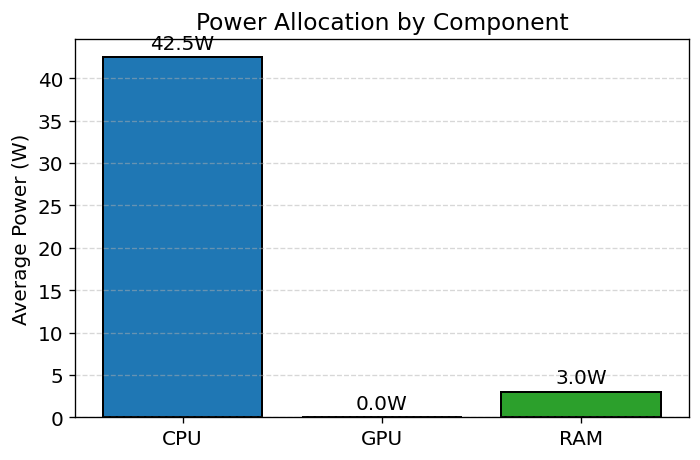

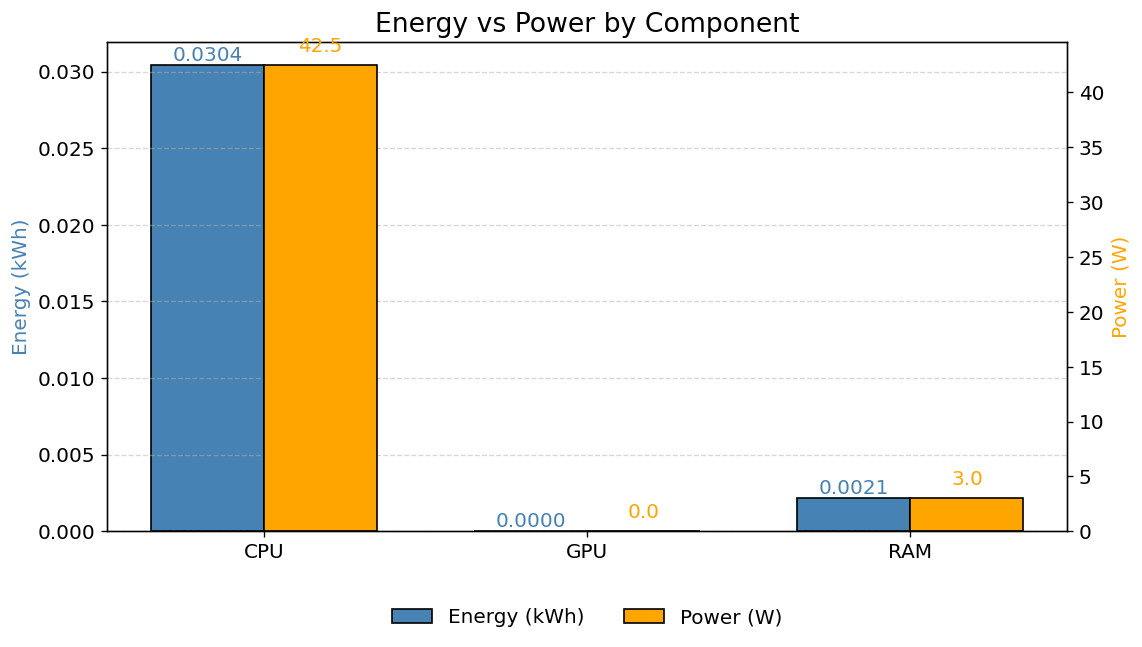

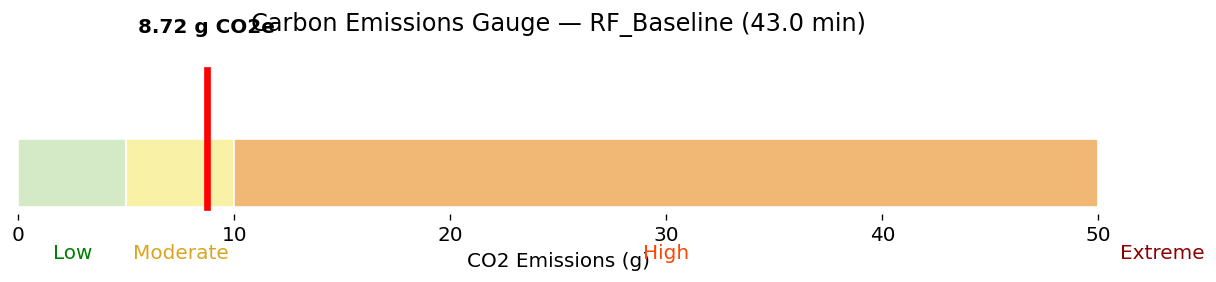

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Increase default DPI for sharper rendering
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['font.size'] = 12

# ——— Load CSV ———
df = pd.read_csv("emissions.csv")

# ——— Aggregate values ———
cpu_energy   = df['cpu_energy'].sum()
gpu_energy   = df['gpu_energy'].sum()
ram_energy   = df['ram_energy'].sum()
cpu_power    = df['cpu_power'].mean()
gpu_power    = df['gpu_power'].mean()
ram_power    = df['ram_power'].mean()
total_energy = df['energy_consumed'].sum()
duration_min = df['duration'].sum() / 60
emissions_g  = df['emissions'].sum() * 1000  # grams
project_name = df['project_name'].iloc[0]

# ——— Prepare DataFrame ———
components = pd.DataFrame({
    "Component":    ["CPU",   "GPU",   "RAM"],
    "Energy (kWh)": [cpu_energy, gpu_energy, ram_energy],
    "Power (W)"    : [cpu_power,  gpu_power,  ram_power]
})
components["% of Total"] = components["Energy (kWh)"] / total_energy * 100

# 1️⃣ Donut Chart: Energy Breakdown with Legend
fig, ax = plt.subplots(figsize=(6,6), dpi=120)
labels = components["Component"]
sizes  = components["Energy (kWh)"]
colors = ['#1f77b4','#ff7f0e','#2ca02c']

wedges, texts, autotexts = ax.pie(
    sizes,
    autopct='%1.1f%%',
    pctdistance=0.75,
    startangle=90,
    colors=colors,
    wedgeprops={'width':0.3, 'edgecolor':'white', 'linewidth':2},
    textprops={'fontsize':12, 'weight':'bold'}
)

# Draw center circle
centre = plt.Circle((0,0),0.45, fc='white')
ax.add_artist(centre)

# Legend outside
ax.legend(
    wedges, labels,
    title="Component",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize=12
)

ax.set_title("Energy Breakdown by Component (kWh)", fontsize=14, pad=20)
ax.axis('equal')
plt.tight_layout()
plt.show()

# 2️⃣ Bar Chart: Power Allocation
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
bars = ax.bar(
    components["Component"],
    components["Power (W)"],
    color=colors,
    edgecolor='black',
    linewidth=1.2
)
ax.set_title("Power Allocation by Component", fontsize=14)
ax.set_ylabel("Average Power (W)")
ax.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + 0.5,
        f"{h:.1f}W",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

# 3️⃣ Dual-Axis Bar Chart: Energy vs Power
fig, ax1 = plt.subplots(figsize=(10,6), dpi=120)
ax2 = ax1.twinx()

x = np.arange(len(components))
width = 0.35

b1 = ax1.bar(x - width/2, components["Energy (kWh)"], width,
             label="Energy (kWh)", color="steelblue", edgecolor='black', linewidth=1)
b2 = ax2.bar(x + width/2, components["Power (W)"], width,
             label="Power (W)", color="orange",    edgecolor='black', linewidth=1)

ax1.set_xticks(x)
ax1.set_xticklabels(components["Component"])
ax1.set_ylabel("Energy (kWh)", color="steelblue")
ax2.set_ylabel("Power (W)",    color="orange")
ax1.set_title("Energy vs Power by Component", fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate
for bar in b1:
    h = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        h + total_energy*0.001,
        f"{h:.4f}",
        ha='center',
        va='bottom',
        color='steelblue'
    )
for bar in b2:
    h = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        h + max(components["Power (W)"])*0.02,
        f"{h:.1f}",
        ha='center',
        va='bottom',
        color='orange'
    )

# Combined legend
l1, l1_labels = ax1.get_legend_handles_labels()
l2, l2_labels = ax2.get_legend_handles_labels()
ax1.legend(
    l1 + l2, l1_labels + l2_labels,
    loc='upper center', bbox_to_anchor=(0.5, -0.12),
    ncol=2, frameon=False
)

plt.subplots_adjust(left=0.1, right=0.9, top=0.88, bottom=0.2)
plt.show()

# 4️⃣ Gauge: Carbon Emissions with Colored Zones
fig, ax = plt.subplots(figsize=(10,2.5), dpi=120)
zones = [0, 5, 10, 50]
zone_colors = ["#d4eac7", "#f9f1a5", "#f0b775"]

for start, end, col in zip(zones[:-1], zones[1:], zone_colors):
    ax.barh(0, end-start, left=start, height=0.4, color=col, edgecolor='white')

# Needle
ax.plot([emissions_g, emissions_g], [-0.2, 0.6], color="red", linewidth=4)

# Zone labels
label_y = -0.5
ax.text((zones[0]+zones[1])/2, label_y, "Low", ha='center', color="green")
ax.text((zones[1]+zones[2])/2, label_y, "Moderate", ha='center', color="goldenrod")
ax.text((zones[2]+zones[3])/2, label_y, "High", ha='center', color="orangered")
ax.text(zones[3] + zones[3]*0.02, label_y, "Extreme", ha='left', color="darkred")

# Styling
ax.set_xlim(zones[0], zones[-1])
ax.set_yticks([])
ax.set_xlabel("CO2 Emissions (g)", fontsize=12)
ax.set_title(f"Carbon Emissions Gauge — {project_name} ({duration_min:.1f} min)", pad=20)
ax.text(emissions_g, 0.8, f"{emissions_g:.2f} g CO2e", ha='center', va='bottom', weight='bold')

plt.subplots_adjust(left=0.05, right=0.95, top=0.75, bottom=0.25)
plt.box(False)
plt.show()


In [11]:

import json
import pandas as pd
from joblib import load

# 1. Load scaler & model
scaler = load("/Users/kiransaud/Desktop/XAI-SHAP/models/scaler.pkl")
rf     = load("/Users/kiransaud/Desktop/XAI-SHAP/models/rf_baseline.pkl")

# 2. (Optional) Load your optimal threshold
with open("/Users/kiransaud/Desktop/XAI-SHAP/models/threshold.json") as f:
    thresh = json.load(f)["threshold"]



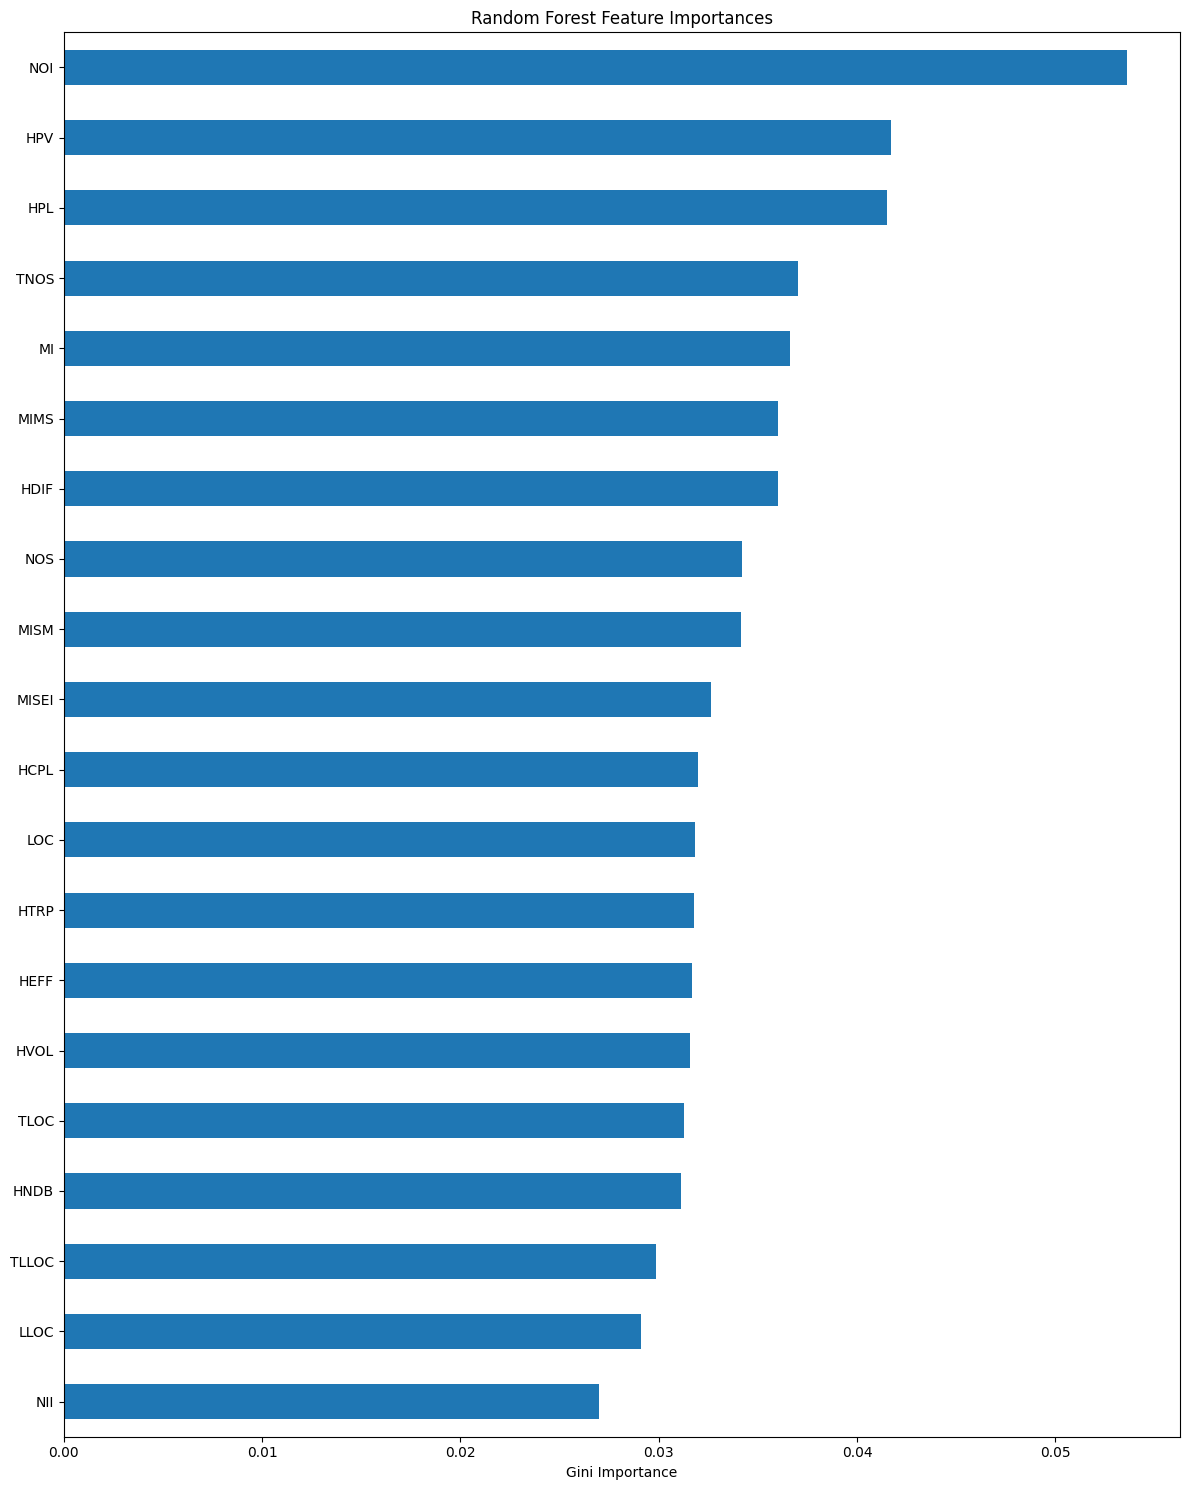

In [19]:
# Suppose you have a DataFrame X_new of new raw data:
import matplotlib.pyplot as plt
raw = pd.read_excel(
    "/Users/kiransaud/Desktop/XAI-SHAP/dataset/dataset.xlsx",
    sheet_name="method"
)

df_clean = (
    raw
    .drop(["Project", "Hash", "LongName", "Number of Bugs"], axis=1)
    .drop_duplicates()
)

# 3) Split off your features
X_new = df_clean.drop("Buggy", axis=1)

# 4) Scale
X_new_scaled = pd.DataFrame(
    scaler.transform(X_new),
    columns = X_new.columns,
    
)

# 5) Extract & sort importances
importances = pd.Series(
    rf.feature_importances_,
    index = X_new_scaled.columns
).sort_values(ascending=True).tail(20)  # Get top 20 features

# 6) Plot horizontal bar chart
plt.figure(figsize=(12, 15))
importances.plot.barh()
plt.xlabel("Gini Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [2]:
# creating background dataset for SHAP because SHAP needs a background dataset to compute the expected value of the model output.
import pandas as pd
import joblib

# Load and clean data
df = pd.read_excel("/Users/kiransaud/Desktop/XAI-SHAP/dataset/dataset.xlsx", sheet_name="method")
df = df.drop(["Project", "Hash", "LongName", "Number of Bugs"], axis=1).drop_duplicates()
X = df.drop("Buggy", axis=1)

# Load scaler and transform
scaler = joblib.load("models/scaler.pkl")
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

# Sample 100 rows as SHAP background
background = X_scaled.sample(n=200, random_state=42)
background.to_pickle("models/background.pkl")

print("✅ Background sample created and saved.")


✅ Background sample created and saved.


In [278]:
def generate_final_html_chart_and_description(probability: float,
                                               threshold: float,
                                               model_desc: str = "Random Forest (v1) with SHAP-based explanation",
                                               full_page_html_path: str = "defect_risk_explained.html"):
    """
    Generates a clean HTML file that includes:
    1. A Plotly bar chart (probability vs. threshold).
    2. A scrollable, well-formatted explanation block styled using HTML/CSS (not in annotations).
    """
    import plotly.graph_objects as go

    prob_pct = probability * 100
    thr_pct = threshold * 100
    decision = "BUGGY" if probability >= threshold else "NOT BUGGY"
    decision_color = "#E74C3C" if decision == "BUGGY" else "#2ECC71"
    relation = "above" if probability >= threshold else "below"
    confidence_gap = abs(prob_pct - thr_pct)

    # Create the figure
    fig = go.Figure()
    fig.add_trace(go.Bar(x=["Decision Threshold"], y=[thr_pct], name="Decision Threshold",
                         marker_color="#4682B4", width=0.5))
    fig.add_trace(go.Bar(x=["Predicted Probability"], y=[prob_pct], name="Predicted Probability",
                         marker_color=decision_color, width=0.5))

    fig.update_layout(
        title=dict(
            text="<b>Software Defect Prediction Analysis</b>",
            x=0.5,
            xanchor="center",
            font=dict(size=22)
        ),
        annotations=[
            dict(
                x=0.5,
                y=1.07,
                xref="paper",
                yref="paper",
                text=f"<span style='font-size:16px; font-weight:bold; color:{decision_color};'>🐞 Classification: {decision}</span>",
                showarrow=False,
                xanchor="center"
            )
        ],
        xaxis_title="Metric",
        yaxis=dict(range=[0, 100], title="Probability (%)", ticksuffix="%"),
        legend=dict(orientation="h", y=1.12, x=0.5, xanchor="center"),
        margin=dict(t=150, b=100, l=80, r=80),
        template="plotly_white",
        height=600
    )

    fig.add_shape(
        type="line",
        x0=-0.5, y0=thr_pct, x1=1.5, y1=thr_pct,
        xref='x', yref='y',
        line=dict(color='red', width=2, dash='dash'),
        opacity=0.7
    )

    chart_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

    # Description block as plain HTML
    description_block = f"""
    <div style="max-width: 960px; margin: 40px auto; padding: 25px; font-family: Arial; font-size: 15px;
                line-height: 1.7; border: 1px solid #ccc; background: #f9f9f9;">
        <h2>🧠 What This Diagram Shows</h2>
        <p>This visualization supports our thesis on the use of <b>SHAP (SHapley Additive Explanations)</b> 
        in software defect prediction. It presents the predicted probability that a given software component 
        contains a post-release defect, compared to a decision threshold.</p>

        <p><b style="color:#4682B4;">📏 Decision Threshold (τ = {thr_pct:.1f}%):</b> 
        This value was selected through threshold optimization techniques to balance between false positives 
        and recall. Any prediction above this threshold is flagged as <b>BUGGY</b>.</p>

        <p><b style="color:{decision_color};">📊 Predicted Probability (P(defect|X) = {prob_pct:.1f}%):</b> 
        Calculated using a Random Forest model trained on software metrics. SHAP values are later used 
        to interpret these results in a stakeholder-specific manner.</p>

        <p><b>🔍 Classification:</b> This component is classified as 
        <b style="color:{decision_color};">{decision}</b> because its probability is {relation} 
        the threshold by {confidence_gap:.1f}%.</p>

        <p><b>🎓 Thesis Context:</b> Part of an empirical study to evaluate how SHAP explanations can enhance 
        trust and usability of defect predictions for different roles in software development (e.g., 
        developers, QA engineers, project managers).</p>

        <p style="font-style: italic; color: #666;">Model: {model_desc} • Metrics: AUC-ROC, F1, PR-AUC • 
        Evaluation: SHAP + stakeholder interviews</p>
    </div>
    """

    full_html = f"""
    <html>
    <head>
        <meta charset="UTF-8">
        <title>Software Defect Risk Summary</title>
    </head>
    <body style="background-color:#ffffff; padding: 40px;">
        {chart_html}
        {description_block}
    </body>
    </html>
    """

    with open(full_page_html_path, "w") as f:
        f.write(full_html)

    return full_page_html_path

fig.show()
# Execute the fixed version
generate_final_html_chart_and_description(probability=0.87, threshold=0.215)


'defect_risk_explained.html'

In [ ]:

import shap
import numpy as np
import joblib
import pandas as pd
from codecarbon import EmissionsTracker
import os
from sklearn.model_selection import train_test_split

SAMPLE_SIZE = 4000

# Load model + scaler + background
rf_model = joblib.load("models/rf_baseline.pkl")
scaler = joblib.load("models/scaler.pkl")
background = pd.read_pickle("models/background.pkl")

# Load and scale the full input
df = pd.read_excel("/Users/kiransaud/Desktop/XAI-SHAP/dataset/dataset.xlsx", sheet_name="method")
df = df.drop(["Project", "Hash", "LongName", "Number of Bugs"], axis=1).drop_duplicates()
X = df.drop("Buggy", axis=1)
y = df["Buggy"]

# Creating stratified sample 
X_sample, _, y_sample, _ = train_test_split(X, 
                                           y,
                                           train_size=SAMPLE_SIZE,
                                           stratify=y,
                                           random_state=42)

X_scaled = pd.DataFrame(scaler.transform(X_sample), columns=X.columns)

# Print debug info
print(f"X_scaled shape: {X_scaled.shape}")  
print(f"Background shape: {background.shape}")
print(f"Class balance in sample: {y_sample.mean():.1%} buggy")

# Start emissions tracking
tracker = EmissionsTracker(
    project_name="SHAP_Explanation",
    output_dir=".",
    measure_power_secs=30,
    save_to_file=True)
tracker.start()

# Create SHAP explainer with correct workflow for RF classifier
explainer = shap.TreeExplainer(rf_model, background)

# Generate SHAP values - should return list of numpy arrays for binary classifier
shap_values = explainer.shap_values(X_scaled, check_additivity=False)

# Debug output to understand the structure
print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Length of shap_values list: {len(shap_values)}")
    for i, sv in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]: {sv.shape}")
else:
    print(f"Shape of shap_values array: {shap_values.shape}")

# Stop emissions tracker
emissions = tracker.stop()
print(f"🌱 CO₂e emitted during SHAP explanation: {emissions:.6f} kg | Sample: {SAMPLE_SIZE} instances")

# Save SHAP values properly
os.makedirs("explanations", exist_ok=True)

if isinstance(shap_values, list) and len(shap_values) == 2:
    # Format 1: List of arrays (traditional SHAP format)
    np.save("explanations/shap_values_class0.npy", shap_values[0])
    np.save("explanations/shap_values_class1.npy", shap_values[1])
    print(f"SHAP values saved. Class 0 shape: {shap_values[0].shape}, Class 1 shape: {shap_values[1].shape}")
else:
    # Format 2: 3D Tensor (what you're getting)
    # Extract values for class 0 and class 1 separately
    shap_values_class0 = shap_values[:, :, 0]  # Shape: (100, 72)
    shap_values_class1 = shap_values[:, :, 1]  # Shape: (100, 72)
    
    np.save("explanations/shap_values_class0.npy", shap_values_class0)
    np.save("explanations/shap_values_class1.npy", shap_values_class1)
    print(f"SHAP values extracted and saved. Class 0 shape: {shap_values_class0.shape}, Class 1 shape: {shap_values_class1.shape}")

# Save the feature data for reference
X_scaled.to_pickle("explanations/X_scaled.pkl")
print("✅ SHAP explanation process complete.")

[codecarbon WARNING @ 15:10:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 15:10:22] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 15:10:22] [setup] RAM Tracking...
[codecarbon INFO @ 15:10:22] [setup] CPU Tracking...
[codecarbon WARNING @ 15:10:22] We saw that you have a Apple M2 but we don't know it. Please contact us.


X_scaled shape: (4000, 72)
Background shape: (200, 72)
Class balance in sample: 32.4% buggy


[codecarbon WARNING @ 15:10:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 15:10:23] CPU Model on constant consumption mode: Apple M2
[codecarbon WARNING @ 15:10:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:10:23] [setup] GPU Tracking...
[codecarbon INFO @ 15:10:23] No GPU found.
[codecarbon INFO @ 15:10:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:10:23] >>> Tracker's metadata:
[codecarbon INFO @ 15:10:23]   Platform system: macOS-15.3-arm64-arm-64bit
[codecarbon INFO @ 15:10:23]   Python version: 3.10.17
[codecarbon INFO @ 15:10:23]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 15:10:23]   Available RAM

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values array: (4000, 72, 2)
🌱 CO₂e emitted during SHAP explanation: 0.028631 kg | Sample: 4000 instances
SHAP values extracted and saved. Class 0 shape: (4000, 72), Class 1 shape: (4000, 72)
✅ SHAP explanation process complete.


View All Feature Names , renaming for business readable labels 



In [1]:

import pandas as pd
import numpy as np
X_scaled = pd.read_pickle("/Users/kiransaud/Desktop/XAI-SHAP/explanations/X_scaled.pkl")
raw = np.load("/Users/kiransaud/Desktop/XAI-SHAP/explanations/shap_values_class1.npy")

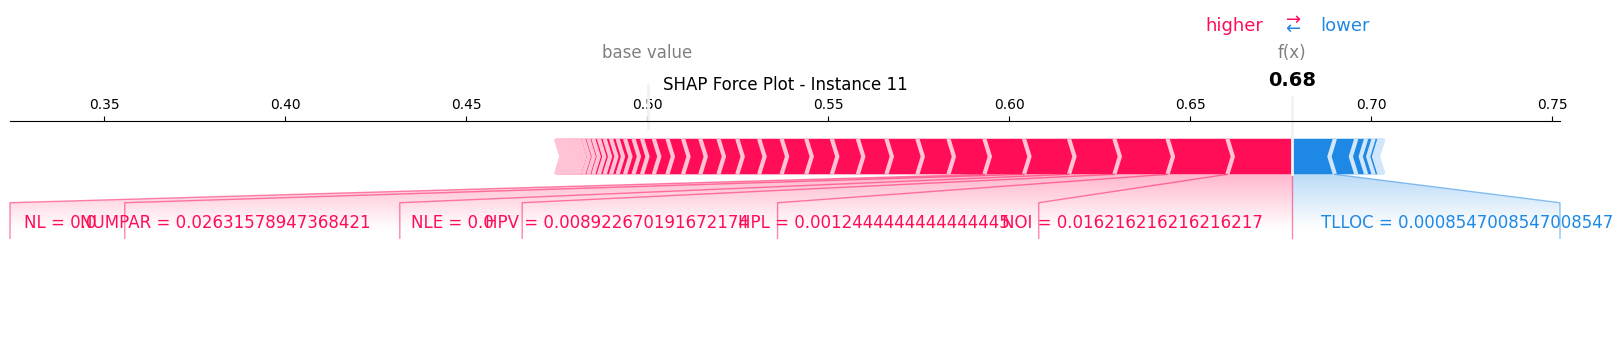

In [45]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt

# Your existing data loading code
X_scaled = pd.read_pickle("/Users/kiransaud/Desktop/XAI-SHAP/explanations/X_scaled.pkl")
raw = np.load("/Users/kiransaud/Desktop/XAI-SHAP/explanations/shap_values_class1.npy")
rf_model = joblib.load('/Users/kiransaud/Desktop/XAI-SHAP/models/rf_baseline.pkl')

explainer = shap.TreeExplainer(rf_model)
base_value = explainer.expected_value
instance_index = 11

# Create and save force plot

shap.plots.force(
    base_value[1],
    raw[instance_index],
    X_scaled.iloc[instance_index],
    feature_names=X_scaled.columns.tolist(),
    matplotlib=True,  # Important: Use matplotlib backend
    show=False        # Important: Don't display immediately
)

# Save the figure
plt.title(f'SHAP Force Plot - Instance {instance_index}')
# plt.savefig(f'force_plot_instance_{instance_index}.png', 
#             dpi=300, 
#             bbox_inches='tight', 
#             facecolor='white')
plt.show()




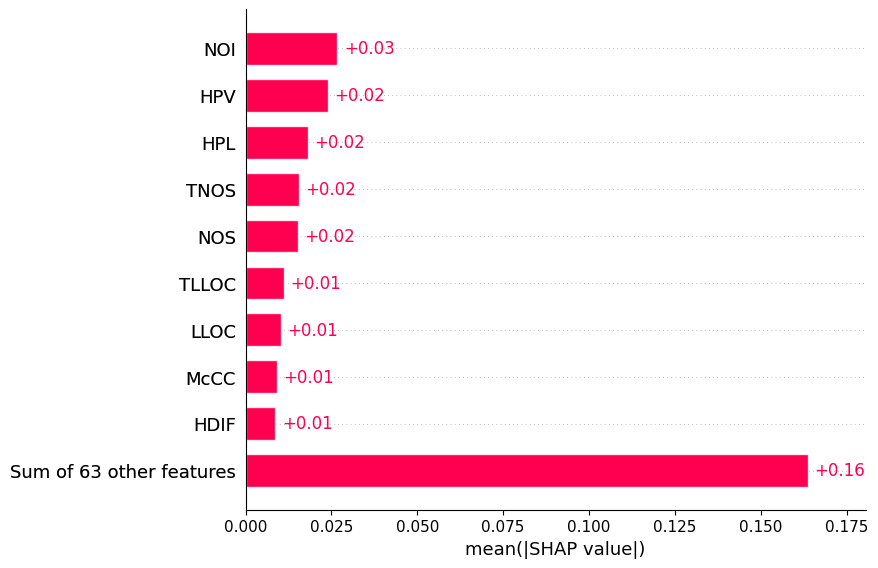

In [62]:
import shap
import pandas as pd
import numpy as np

# Load your data
X_scaled = pd.read_pickle("/Users/kiransaud/Desktop/XAI-SHAP/explanations/X_scaled.pkl")
raw = np.load("/Users/kiransaud/Desktop/XAI-SHAP/explanations/shap_values_class1.npy")
raw2 = np.load("/Users/kiransaud/Desktop/XAI-SHAP/explanations/shap_values_class0.npy")
# Combine both classes into a single array
raw_combined = np.concatenate([raw, raw2], axis=0)


# Create a SHAP Explanation object
shap_values = shap.Explanation(
    values=raw_combined,
    base_values=None,
    data=X_scaled.values,
    feature_names=X_scaled.columns.tolist()
)

# Calculate custom feature importance: max absolute SHAP value per feature

shap.plots.bar(
    shap_values,
    max_display=10,
)


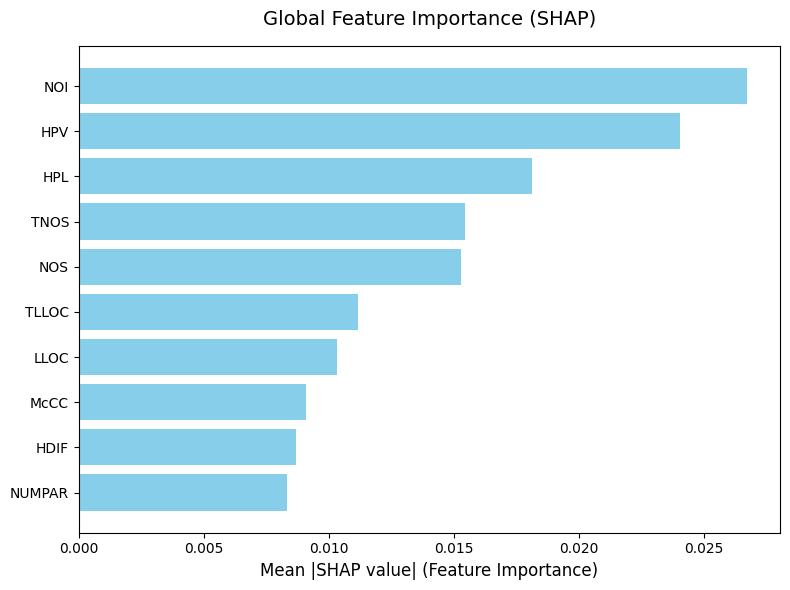

In [3]:
#cite the papers 
# description of the features and dataset
import os
feature_names_map = {
     'CC': 'Code Complexity',
    'CCL': 'Code Complexity (Logic)',
    'CCO': 'Code Complexity (Object)',
    'CI': 'Class Coupling',
    'CLC': 'Class Size (Code)',
    'CLLC': 'Class Size (Logic)',
    'LDC': 'Code Density',
    'LLDC': 'Logical Lines per Class',
    'HCPL': 'Code Readability',
    'HDIF': 'Code Difficulty',
    'HEFF': 'Code Efficiency',
    'HNDB': 'Code Defect Risk',
    'HPL': 'Code Volume (Language)',
    'HPV': 'Code Efficiency (Volume)',
    'HTRP': 'Code Effort',
    'HVOL': 'Code Volume',
    'MI': 'Code Maintainability',
    'MIMS': 'Maintainability (Size)',
    'MISEI': 'Maintainability (Effort)',
    'MISM': 'Maintainability (Structure)',
    'McCC': 'Code Complexity (McCabe)',
    'NL': 'Nested Logic Depth',
    'NLE': 'Nested Logic Exceptions',
    'NII': 'Function Inputs',
    'NOI': 'Function Outputs',
    'CD': 'Code Duplication',
    'CLOC': 'Code Size (Lines)',
    'DLOC': 'Documented Code Size',
    'TCD': 'Code Churn (Total)',
    'TCLOC': 'Code Size (Total)',
    'LLOC': 'Logical Code Size',
    'LOC': 'Lines of Code',
    'NOS': 'Code Statements',
    'NUMPAR': 'Function Parameters',
    'TLLOC': 'Total Logical Code Size',
    'TLOC': 'Total Lines of Code',
    'TNOS': 'Code Churn (Statements)',
    'WarningBlocker': 'Critical Code Warnings',
    'WarningCritical': 'High-Priority Warnings',
    'WarningInfo': 'Informational Warnings',
    'WarningMajor': 'Major Code Warnings',
    'WarningMinor': 'Minor Code Warnings',
    'Android Rules': 'Android Code Standards',
    'Basic Rules': 'Basic Code Standards',
    'Brace Rules': 'Code Style Compliance',
    'Clone Implementation Rules': 'Code Duplication Rules',
    'Code Size Rules': 'Code Size Standards',
    'Comment Rules': 'Documentation Quality',
    'Controversial Rules': 'Code Consistency',
    'Coupling Rules': 'Class Coupling Standards',
    'Design Rules': 'Code Design Quality',
    'Empty Code Rules': 'Dead Code',
    'Finalizer Rules': 'Resource Cleanup',
    'Import Statement Rules': 'Dependency Management',
    'J2EE Rules': 'J2EE Standards',
    'JUnit Rules': 'Test Quality',
    'Jakarta Commons Logging Rules': 'Logging Standards',
    'Java Logging Rules': 'Logging Consistency',
    'JavaBean Rules': 'JavaBean Standards',
    'MigratingToJUnit4 Rules': 'Test Modernization',
    'Migration Rules': 'Legacy Code Migration',
    'Migration13 Rules': 'Java 13 Migration',
    'Migration14 Rules': 'Java 14 Migration',
    'Migration15 Rules': 'Java 15 Migration',
    'Naming Rules': 'Code Readability',
    'Optimization Rules': 'Code Performance',
    'Security Code Guideline Rules': 'Security Standards',
    'Strict Exception Rules': 'Error Handling Quality',
    'String and StringBuffer Rules': 'Code Efficiency',
    'Type Resolution Rules': 'Code Clarity',
    'Unnecessary and Unused Code Rules': 'Dead Code',
    'Vulnerability Rules': 'Security Risks'
}

X_scaled = X_scaled.rename(columns=feature_names_map)
os.makedirs("static/manager", exist_ok=True)



In [4]:

# #These are likely to cause delivery delays, longer testing, or refactoring overhead:
# ## ⏱ Time-related features

# time_features = {
#     "Code Complexity", "Lines with Comments", "Code Object Complexity", "Class Inheritance Depth",
#     "Lines with Logical Comments", "Logical Lines with Comments", "Halstead Program Length",
#     "Halstead Difficulty", "Halstead Effort", "Halstead Volume", "Halstead Volume (Alternative)",
#     "Halstead Time Required", "McCabe Cyclomatic Complexity", "Number of Lines", "Empty Lines",
#     "Logical Lines of Code", "Lines of Code", "Number of Statements", "Number of Parameters",
#     "Total Logical Lines of Code", "Total Lines of Code", "Total Number of Statements",
#     "Brace Formatting Rules", "Large Class/Method Warnings", "Design Quality Guidelines"
# }


# #These features often result in higher QA/dev cost, bug-fix effort, or resource waste:
# # 💰 Cost-related feature
# cost_features = {
#     "Halstead Bugs Estimate", "Maintainability Index", "MI Without Comments", "MI with SEI Formula",
#     "MI with Microsoft Formula", "Number of Internal Invocations", "Number of Invocations",
#     "Code Density", "Comment Lines of Code", "Duplicate Lines of Code", "Total Code Density",
#     "Total Comment Lines of Code", "Critical Code Violations", "High-Severity Warnings",
#     "Informational Warnings", "Major Code Warnings", "Minor Code Warnings", "Android Best Practices",
#     "Basic Java Code Rules", "Duplicate Code Rules", "Comment Quality Rules", "Controversial Code Practices",
#     "Coupling Between Components", "Empty Code Block Warnings", "Finalizer Usage Guidelines",
#     "Import Statement Quality", "J2EE Design Guidelines", "JUnit Test Quality Rules",
#     "Jakarta Logging Best Practices", "Java Util Logging Practices", "JavaBean Compliance",
#     "Migration to JUnit 4 Guidelines", "General Java Migration Rules", "Migration to Java 1.3 Rules",
#     "Migration to Java 1.4 Rules", "Migration to Java 1.5 Rules", "Naming Convention Rules",
#     "Code Optimization Hints", "Security Compliance Checks", "Exception Handling Rules",
#     "String Handling Guidelines", "Type Resolution Warnings", "Dead/Unused Code Detected",
#     "Potential Vulnerabilities Detected"
# }


# Categorized Features with Business-Aligned Names
time_features = [
    "Code Complexity",
    "Code Complexity (Logic)",
    "Code Complexity (Object)",
    "Class Coupling",
    "Class Size (Code)",
    "Class Size (Logic)",
    "Code Density",
    "Logical Lines per Class",
    "Code Readability",
    "Code Difficulty",
    "Code Efficiency",
    "Code Effort",
    "Code Efficiency (Volume)",
    "Code Complexity (McCabe)",
    "Nested Logic Depth",
    "Nested Logic Exceptions",
    "Function Inputs",
    "Function Outputs",
    "Function Parameters",
    "Code Size Standards",
    "Class Coupling Standards",
    "Test Modernization",
    "Code Clarity"
]

cost_features = [
    "Code Defect Risk",
    "Code Duplication",
    "Code Churn (Total)",
    "Code Churn (Statements)",
    "Critical Code Warnings",
    "High-Priority Warnings",
    "Major Code Warnings",
    "Android Code Standards",
    "Code Duplication Rules",
    "Code Design Quality",
    "Dead Code",
    "Resource Cleanup",
    "Security Standards",
    "Legacy Code Migration",
    "Java 13 Migration",
    "Java 14 Migration",
    "Java 15 Migration",
    "Security Risks",
    "J2EE Standards",
    "JavaBean Standards",
    "Basic Code Standards",
    "Dependency Management",
    "Error Handling Quality",
    "Vulnerability Risks"
]

both_features = [
    "Code Maintainability",
    "Maintainability (Size)",
    "Maintainability (Effort)",
    "Maintainability (Structure)",
    "Test Quality",
    "Code Performance"
]

other_features = [
    "Code Volume (Language)",
    "Code Volume",
    "Code Size (Lines)",
    "Documented Code Size",
    "Code Size (Total)",
    "Logical Code Size",
    "Lines of Code",
    "Code Style Compliance",
    "Documentation Quality",
    "Minor Code Warnings",
    "Informational Warnings",
    "Logging Standards",
    "Logging Consistency",
    "Code Readability (Naming)",
    "Code Efficiency (Strings)",
    "Dead Code (Unused)",
    "Code Statements",
    "Total Logical Code Size",
    "Total Lines of Code",
    "Code Consistency"
]

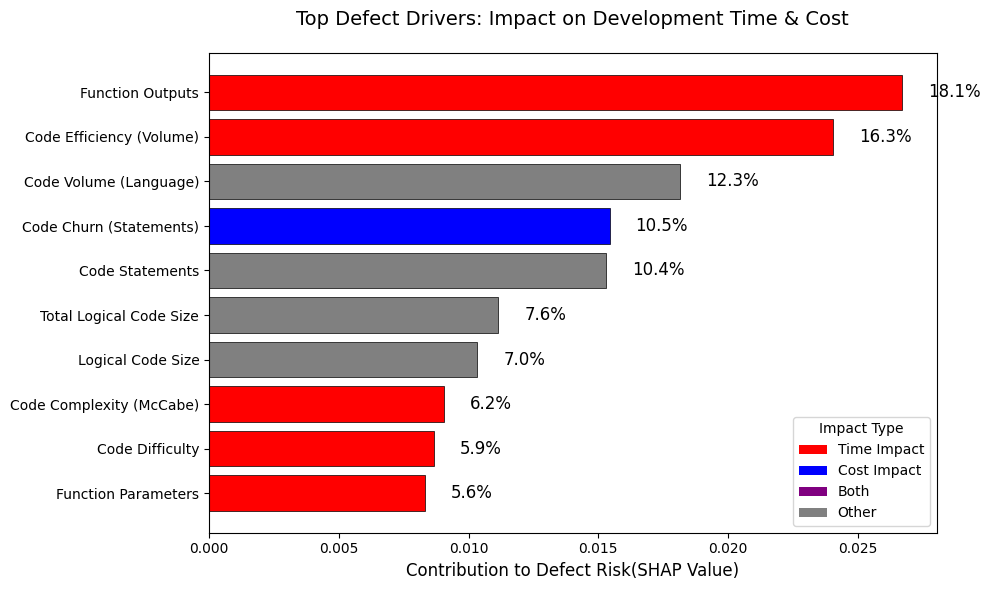

In [5]:
# procedure and workflow for plotting the bar chart
#original SHAP values vs Different stakeholder perspectives
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

mean_abs_shap = np.abs(raw).mean(axis=0)
feature_importance = pd.Series(mean_abs_shap, index=X_scaled.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

# 2. Assign colors based on business impact
colors = []
for feature in top_features.index:
    if feature in time_features:
        colors.append("red")
    elif feature in cost_features:
        colors.append("blue")
    elif feature in both_features:
        colors.append("purple")
    else:
        colors.append("gray")

# 3. Plot using matplotlib
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features.index[::-1], 
                top_features.values[::-1], 
                color=colors[::-1],
                edgecolor='black', linewidth=0.5)
plt.xlabel("Contribution to Defect Risk(SHAP Value)", fontsize=12)
plt.title("Top Defect Drivers: Impact on Development Time & Cost", fontsize=14,pad=20)

# 4. Annotate bar values
for bar in bars:
    width = bar.get_width()
    percent= (width / top_features.values.sum()) * 100
    plt.text(width + 0.001,
             bar.get_y() + bar.get_height() / 2,
             f"{percent:.1f}%", va="center",
             fontsize=12,
             )
    

# 5. Add color legend
legend_elements = [
    Patch(facecolor='red', label='Time Impact'),
    Patch(facecolor='blue', label='Cost Impact'),
    Patch(facecolor='purple', label='Both'),
    Patch(facecolor='gray', label='Other')
]
plt.legend(handles=legend_elements, 
           title="Impact Type",
           )

plt.tight_layout()
plt.show()
# plt.savefig("static/manager/bar_summary_colored.png", bbox_inches='tight')
# plt.clf()

Feature Impact Distribution
summary plot to show how feature values affect defect predictions.SHAP values for each feature, with red (high values) and blue (low values) indicating impact on defect risk.

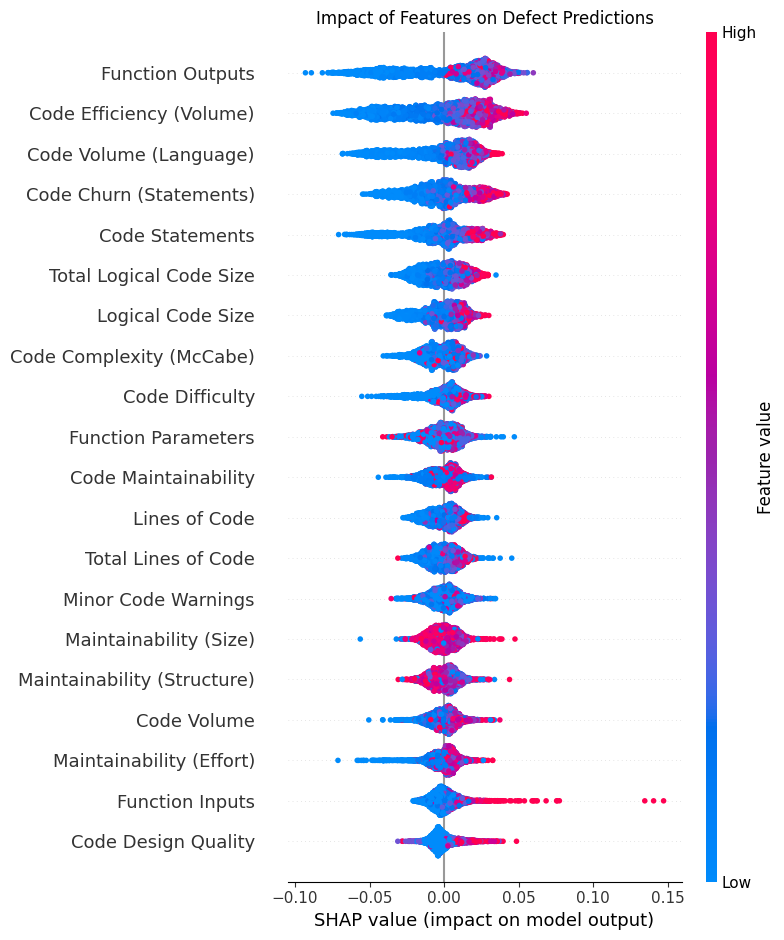

In [6]:
import shap
# Summary plot (dot plot)
shap.summary_plot(raw, X_scaled, show=False)
plt.title("Impact of Features on Defect Predictions")
plt.tight_layout()
plt.show()
# plt.savefig("/Users/kiransaud/Desktop/XAI-SHAP/explanations/summary_plot.png")
plt.close()

In [5]:
#Future Work different feature has different importance wether its defined risky or not .
shap_sums = np.sum(raw, axis=1)
# Create DataFrame
modules = pd.DataFrame({
    "Module": X_scaled.index,  # Use index or module names if available
    "SHAP_Sum": shap_sums
})

# Sort by SHAP sum and select top 5
high_risk_modules = modules.sort_values(by="SHAP_Sum", ascending=False).head(5)

# Get top 3 contributing features for each high-risk module
top_features = []
for idx in high_risk_modules.index:
    shap_row = raw[idx]
    top_idx = np.argsort(np.abs(shap_row))[-3:]  # Top 3 features
    top_contributors = [(X_scaled.columns[i], round(shap_row[i], 3)) for i in top_idx]
    top_features.append(top_contributors)

high_risk_modules["Top_Contributors"] = top_features

# Save to CSV
high_risk_modules.to_csv("/Users/kiransaud/Desktop/XAI-SHAP/explanations/high_risk_modules.csv", index=False)


Model quality influence on explanation

A SHAP dependence plot shows how one specific feature (like NOI) affects the model’s predictions (e.g., likelihood of a software module being defective), while also considering how it interacts with another feature (like HPV). Think of it as a graph that answers: “How does changing this feature change our defect prediction, and does another feature play a role in that?”

In [ ]:
import pandas as pd
import numpy as np
import shap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
import warnings
warnings.filterwarnings('ignore')

# Load your data
X_scaled = pd.read_pickle("/Users/kiransaud/Desktop/XAI-SHAP/explanations/X_scaled.pkl")
shap_values_class1 = np.load("/Users/kiransaud/Desktop/XAI-SHAP/explanations/shap_values_class1.npy")

# Apply friendly names
X_scaled.columns = [feature_names_map.get(col, col) for col in X_scaled.columns]
os.makedirs("static/manager", exist_ok=True)

def find_most_important_feature(shap_values, X_data):
    """
    Identify the single most important feature for defect prediction
    """
    # Calculate feature importance (mean absolute SHAP values)
    feature_importance = np.mean(np.abs(shap_values), axis=0)
    
    # Get the most important feature
    most_important_idx = np.argmax(feature_importance)
    most_important_feature = X_data.columns[most_important_idx]
    importance_score = feature_importance[most_important_idx]
    
    print("🎯 MOST CRITICAL FACTOR FOR DEFECT PREDICTION:")
    print("="*60)
    print(f"Feature: {most_important_feature}")
    print(f"Importance Score: {importance_score:.4f}")
    print(f"This factor explains {importance_score/np.sum(feature_importance)*100:.1f}% of all defect risk factors")
    print("="*60)
    
    return most_important_feature, most_important_idx, importance_score

def get_detailed_business_context(feature_name):
    """
    Provide comprehensive business context for the feature
    """
    feature_lower = feature_name.lower()
    
    contexts = {
        'code complexity': {
            'what_it_is': 'Code Complexity measures how difficult code is to understand and maintain. It counts decision points like if-statements, loops, and switches.',
            'why_important': 'Complex code is harder for developers to understand, leading to more mistakes during changes and maintenance.',
            'business_impact': 'High complexity increases development time, makes bug fixing harder, and increases the likelihood of introducing new defects.',
            'good_range': 'Industry standard: Keep complexity below 10 for most functions, below 15 for complex business logic.',
            'warning_signs': 'Functions with complexity > 20 are extremely risky and should be refactored immediately.',
            'recommendations': [
                'Review all modules with complexity > 15',
                'Make complexity checking mandatory in code reviews',
                'Set up automated complexity alerts in CI pipeline',
                'Train developers on complexity reduction techniques',
                'Allocate 20% of sprint time for refactoring'
            ]
        },
        'lines of code': {
            'what_it_is': 'Lines of Code measures the size of code modules. Larger modules contain more functionality.',
            'why_important': 'Larger modules are statistically more likely to contain defects simply because there is more code that can go wrong.',
            'business_impact': 'Large modules take longer to test, are harder to review thoroughly, and increase maintenance costs.',
            'good_range': 'Best practice: Keep classes under 300 lines, methods under 50 lines.',
            'warning_signs': 'Modules over 1000 lines should be considered for breaking into smaller components.',
            'recommendations': [
                'Break down modules larger than 500 lines',
                'Establish maximum size limits (300 lines for classes)',
                'Large modules require 2+ reviewers instead of 1',
                'Increase test coverage for large modules to 90%+',
                'Schedule monthly "module splitting" sessions'
            ]
        },
        'code churn': {
            'what_it_is': 'Code Churn measures how frequently code is modified. High churn means the code changes often.',
            'why_important': 'Frequently changed code is more likely to introduce defects due to constant modifications.',
            'business_impact': 'High churn areas consume more development resources and are hotspots for production issues.',
            'good_range': 'Stable modules should have low churn. New features naturally have higher churn.',
            'warning_signs': 'Legacy modules with sudden high churn may indicate architectural problems.',
            'recommendations': [
                'Extra testing for high-churn modules',
                'Require pair programming for high-churn areas',
                'Weekly churn reports for stakeholders',
                'Increase automated test coverage',
                'Consider feature freeze for most volatile modules'
            ]
        }
    }
    
    # Find matching context or provide generic one
    for key, context in contexts.items():
        if key in feature_lower:
            return context
    
    # Generic context for other features
    return {
        'what_it_is': f'{feature_name} is a software quality metric that measures a specific aspect of code quality.',
        'why_important': 'This metric has been identified as a strong predictor of software defects in your codebase.',
        'business_impact': 'Modules with extreme values of this metric require additional attention during development and testing.',
        'good_range': 'Optimal ranges should be established based on your project\'s historical data and industry benchmarks.',
        'warning_signs': 'Modules in the top 25% of this metric should be flagged for additional review.',
        'recommendations': [
            'Flag high-risk modules for review',
            'Track this metric in project dashboard',
            'Add to definition-of-done checklist',
            'Train team about this quality factor',
            'Set quarterly improvement goals'
        ]
    }

def create_interactive_dependence_plot(feature_name, shap_values, X_data, save_path=None):
    """
    Create comprehensive interactive Plotly dashboard for project managers
    """
    feature_idx = list(X_data.columns).index(feature_name)
    x_values = X_data[feature_name].values
    y_values = shap_values[:, feature_idx]
    
    # Calculate risk categories for each module
    risk_categories = []
    risk_colors = []
    for y_val in y_values:
        if y_val > 0.2:
            risk_categories.append('High Risk')
            risk_colors.append('#FF4444')
        elif y_val > 0.05:
            risk_categories.append('Moderate Risk') 
            risk_colors.append('#FFA500')
        else:
            risk_categories.append('Low Risk')
            risk_colors.append('#4CAF50')
    
    # Create subplot layout
    fig = make_subplots(
        rows=3, cols=3,
        subplot_titles=(
            f'🎯 How {feature_name} Affects Defect Risk', 
            '📊 Risk Distribution', 
            f'📈 {feature_name} Distribution',
            '📋 Business Context', 
            '🎯 Action Plan', 
            '📊 Key Statistics'
        ),
        specs=[
            [{"colspan": 3}, None, None],
            [{"type": "domain"}, {"type": "xy"}, {"type": "table"}],
            [{"colspan": 3}, None, None]
        ],
        row_heights=[0.5, 0.3, 0.2],
        vertical_spacing=0.08
    )
    
    # Main scatter plot with enhanced interactivity
    hover_text = [
        f"<b>Module #{i+1}</b><br>" +
        f"{feature_name}: {x_val:.2f}<br>" +
        f"Defect Risk Impact: {y_val:.3f}<br>" +
        f"Risk Level: {risk_cat}<br>" +
        f"<i>Click to highlight similar modules</i>"
        for i, (x_val, y_val, risk_cat) in enumerate(zip(x_values, y_values, risk_categories))
    ]
    
    # Add scatter plot with custom hover
    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=y_values,
            mode='markers',
            marker=dict(
                size=10,
                color=y_values,
                colorscale='RdBu_r',
                showscale=True,
            colorbar=dict(
    title=dict(
        text="<b>Defect Risk Impact</b><br>Red = Higher Risk<br>Blue = Lower Risk",
        side="right"
    ),
    x=1.02
),

                line=dict(width=1, color='black'),
                opacity=0.8
            ),
            text=hover_text,
            hovertemplate='%{text}<extra></extra>',
            name='Code Modules'
        ),
        row=1, col=1
    )
    
    # Add trend line
    z = np.polyfit(x_values, y_values, 2)
    p = np.poly1d(z)
    x_trend = np.linspace(x_values.min(), x_values.max(), 100)
    y_trend = p(x_trend)
    
    fig.add_trace(
        go.Scatter(
            x=x_trend,
            y=y_trend,
            mode='lines',
            line=dict(color='red', width=3, dash='dash'),
            name='Trend Line',
            hovertemplate='<b>Trend Line</b><br>%{x:.2f} → %{y:.3f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add risk zones as shapes
    fig.add_shape(
        type="rect",
        x0=x_values.min(), x1=x_values.max(),
        y0=0, y1=max(y_values.max(), 0.1),
        fillcolor="red", opacity=0.1,
        layer="below", line_width=0,
        row=1, col=1
    )
    
    fig.add_shape(
        type="rect", 
        x0=x_values.min(), x1=x_values.max(),
        y0=min(y_values.min(), -0.1), y1=0,
        fillcolor="blue", opacity=0.1,
        layer="below", line_width=0,
        row=1, col=1
    )
    
    # Add horizontal line at y=0
    fig.add_hline(y=0, line_dash="dot", line_color="black", opacity=0.5, row=1, col=1)
    
    # Risk distribution pie chart
    risk_counts = pd.Series(risk_categories).value_counts()
    fig.add_trace(
        go.Pie(
            labels=risk_counts.index,
            values=risk_counts.values,
            marker_colors=['#4CAF50', '#FFA500', '#FF4444'],
            hovertemplate='<b>%{label}</b><br>%{value} modules (%{percent})<extra></extra>',
            textinfo='label+percent',
            textfont_size=12
        ),
        row=2, col=1
    )
    
    # Feature distribution histogram
    fig.add_trace(
        go.Histogram(
            x=x_values,
            nbinsx=30,
            marker_color='skyblue',
            marker_line_color='black',
            marker_line_width=1,
            opacity=0.7,
            hovertemplate='<b>Range:</b> %{x}<br><b>Count:</b> %{y} modules<extra></extra>'
        ),
        row=2, col=2
    )
    
    # Statistics table
    correlation = np.corrcoef(x_values, y_values)[0, 1]
    q25, q50, q75 = np.percentile(x_values, [25, 50, 75])
    high_risk_count = sum(1 for cat in risk_categories if cat == 'High Risk')
    
    stats_data = [
        ['Total Modules', f'{len(x_values):,}'],
        ['Correlation Strength', f'{correlation:.3f}'],
        ['High Risk Modules', f'{high_risk_count:,} ({high_risk_count/len(x_values)*100:.1f}%)'],
        [f'{feature_name} Median', f'{q50:.2f}'],
        [f'{feature_name} Range', f'{x_values.min():.1f} - {x_values.max():.1f}'],
        ['Avg Risk Impact', f'{np.mean(y_values):.3f}']
    ]
    
    fig.add_trace(
        go.Table(
            header=dict(
                values=['<b>Metric</b>', '<b>Value</b>'],
                fill_color='lightblue',
                font=dict(size=12)
            ),
            cells=dict(
                values=list(zip(*stats_data)),
                fill_color='white',
                font=dict(size=11),
                height=25
            )
        ),
        row=2, col=3
    )
    
    # Update layout for professional appearance
    fig.update_layout(
        title=dict(
            text=f"<b>🎯 CRITICAL BUSINESS INSIGHT: {feature_name} Impact Analysis</b><br>" +
                 f"<span style='font-size:14px'>Your #1 predictor of software defects - Interactive Dashboard for Project Managers</span>",
            x=0.5,
            font=dict(size=20)
        ),
        height=1200,
        showlegend=False,
        template='plotly_white',
        font=dict(family="Arial", size=12),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
    
    # Update axes
    fig.update_xaxes(
        title_text=f"<b>{feature_name}</b><br><i>(Each point = one code module)</i>",
        title_font=dict(size=14),
        row=1, col=1
    )
    
    fig.update_yaxes(
        title_text="<b>Impact on Defect Risk</b><br><i>(Positive = Higher Risk)</i>",
        title_font=dict(size=14),
        row=1, col=1
    )
    
    fig.update_xaxes(title_text=f"<b>{feature_name} Value</b>", row=2, col=2)
    fig.update_yaxes(title_text="<b>Number of Modules</b>", row=2, col=2)
    
    # Add annotations for business context
    context = get_detailed_business_context(feature_name)
    
    business_context_text = (
        f"<b> WHAT IS {feature_name.upper()}?</b><br>"
        f"• {context['what_it_is']}<br><br>"
        f"<b> BUSINESS IMPACT:</b><br>"
        f"• {context['business_impact']}<br><br>"
        f"<b>INDUSTRY STANDARDS:</b><br>"
        f"• {context['good_range']}<br><br>"
        f"<b>WARNING SIGNS:</b><br>"
        f"• {context['warning_signs']}"
    )
    
    fig.add_annotation(
        text=business_context_text,
        xref="paper", yref="paper",
        x=0.1, y=0,
        xanchor="left", yanchor="bottom",
        bgcolor="lightyellow",
        bordercolor="orange",
        borderwidth=1,
        font=dict(size=10),
        showarrow=False,
        width=500
    )
    
    
    
    # ROI calculation annotation
    high_risk_modules = sum(1 for y in y_values if y > 0.1)

    if high_risk_modules > 0:
        # compute ROI normally
        est_defects_prevented = int(high_risk_modules * 0.4)
        prevention_cost_total = high_risk_modules * 300
        roi_pct = int((est_defects_prevented * 5000) / prevention_cost_total * 100)
        roi_text = (
            f"<b>💰 BUSINESS CASE:</b><br>"
            f"• High-risk modules: {high_risk_modules}<br>"
            f"• Est. defects prevented: {est_defects_prevented}<br>"
            f"• Cost per production defect: $5,000<br>"
            f"• Prevention cost: $300/module<br>"
            f"• <b>Potential ROI: {roi_pct}%</b>"
        )
    else:
        # avoid divide-by-zero
        roi_text = (
            f"<b>💰 BUSINESS CASE:</b><br>"
            f"• High-risk modules: 0 <br>"
            f"• <i>No high-risk modules detected, so ROI is N/A</i>"
        )
    
    fig.add_annotation(
        text=roi_text,
        xref="paper", yref="paper",
        x=0.68, y=0.35, 
        xanchor="left", yanchor="top",
        bgcolor="lightcyan",
        bordercolor="blue",
        borderwidth=1,
        font=dict(size=10),
        showarrow=False,
        width=250
    )
    
    # Save as HTML for Django
    if save_path:
        # Save as HTML file for Django embedding
        html_path = save_path.replace('.png', '.html')
        fig.write_html(html_path, include_plotlyjs='cdn')
        print(f"Interactive HTML saved to: {html_path}")
        
        # Also save as standalone HTML with embedded JS
        standalone_path = save_path.replace('.png', '_standalone.html')
        fig.write_html(standalone_path, include_plotlyjs=True)
        print(f"Standalone HTML saved to: {standalone_path}")
    
    return fig

def generate_django_view_code(feature_name):
    """
    Generate Django view code for easy integration
    """
    view_code = f'''
# Django views.py
from django.shortcuts import render
from django.http import JsonResponse
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def defect_analysis_dashboard(request):
    """
    Interactive SHAP analysis dashboard for project managers
    """
    # Load your data (replace with your actual data loading)
    X_scaled = pd.read_pickle("path/to/X_scaled.pkl")
    shap_values = np.load("path/to/shap_values_class1.npy")
    
    # Create interactive plot
    fig = create_interactive_dependence_plot(
        feature_name="{feature_name}",
        shap_values=shap_values,
        X_data=X_scaled
    )
    
    # Convert to HTML
    graph_html = fig.to_html(include_plotlyjs='cdn', div_id="defect-analysis-plot")
    
    context = {{
        'graph_html': graph_html,
        'feature_name': "{feature_name}",
        'page_title': 'Software Defect Risk Analysis Dashboard'
    }}
    
    return render(request, 'analysis/dashboard.html', context)

# For AJAX updates
def update_analysis(request):
    """
    Update analysis based on user selections
    """
    feature_name = request.GET.get('feature', '{feature_name}')
    
    # Regenerate plot with new parameters
    fig = create_interactive_dependence_plot(feature_name, shap_values, X_data)
    
    return JsonResponse({{
        'graph_html': fig.to_html(include_plotlyjs=False, div_id="defect-analysis-plot")
    }})
'''
    
    template_code = '''
<!-- analysis/dashboard.html -->
<!DOCTYPE html>
<html>
<head>
    <title>{{ page_title }}</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; }
        .dashboard-header { text-align: center; margin-bottom: 30px; }
        .export-buttons { margin: 20px 0; text-align: center; }
        .btn { padding: 10px 20px; margin: 5px; background: #007bff; color: white; text-decoration: none; border-radius: 5px; }
    </style>
</head>
<body>
    <div class="dashboard-header">
        <h1>🎯 Software Defect Risk Analysis</h1>
        <p>Interactive Dashboard for Project Managers</p>
    </div>
    
    <div class="export-buttons">
        <a href="#" class="btn" onclick="exportToPNG()">📊 Export as PNG</a>
        <a href="#" class="btn" onclick="exportToPDF()">📄 Export as PDF</a>
        <a href="#" class="btn" onclick="printReport()">🖨️ Print Report</a>
    </div>
    
    {{ graph_html|safe }}
    
    <script>
        function exportToPNG() {
            Plotly.downloadImage('defect-analysis-plot', {
                format: 'png',
                width: 1200,
                height: 800,
                filename: 'defect_risk_analysis'
            });
        }
        
        function exportToPDF() {
            Plotly.downloadImage('defect-analysis-plot', {
                format: 'pdf',
                width: 1200, 
                height: 800,
                filename: 'defect_risk_analysis'
            });
        }
        
        function printReport() {
            window.print();
        }
    </script>
</body>
</html>
'''
    
    print("="*60)
    print("🚀 DJANGO INTEGRATION CODE:")
    print("="*60)
    print(view_code)
    print("\n" + "="*60)
    print("📄 HTML TEMPLATE:")
    print("="*60) 
    print(template_code)

# Main execution
if __name__ == "__main__":
    print("🔍 CREATING INTERACTIVE PLOTLY DASHBOARD...")
    print("="*60)
    
    # Find the most important feature
    most_important_feature, feature_idx, importance_score = find_most_important_feature(
        shap_values_class1, X_scaled
    )
    
    print(f"\n🎨 GENERATING INTERACTIVE VISUALIZATION FOR: {most_important_feature}")
    
    # Create the interactive plot
    save_path = f"static/manager/INTERACTIVE_{most_important_feature.replace(' ', '_').replace('(', '').replace(')', '')}.html"
    
    fig = create_interactive_dependence_plot(
        feature_name=most_important_feature,
        shap_values=shap_values_class1,
        X_data=X_scaled,
        save_path=save_path
    )
    
    # Generate Django integration code
    generate_django_view_code(most_important_feature)
    
    print(f"\nINTERACTIVE DASHBOARD CREATED!")
    print(f" Files saved for Django integration")
    print(f"\n KEY BENEFITS FOR PROJECT MANAGERS:")
    print(f"Interactive hover details")
    print(f"Clickable risk zones") 
    print(f" Export functionality (PNG/PDF)")
    print(f"✓ Mobile-responsive design")
    print(f"✓ Professional dashboard appearance")
    print(f"✓ Real-time data exploration")
    
    # Display the plot
    fig.show()

This chart shows why our top three risky modules are predicted to have defects. It tracks how each code factor adds to or reduces that risk."
"The starting point is our average defect chance (0.3), and the end point is the final prediction, compared to our threshold of 0.5."

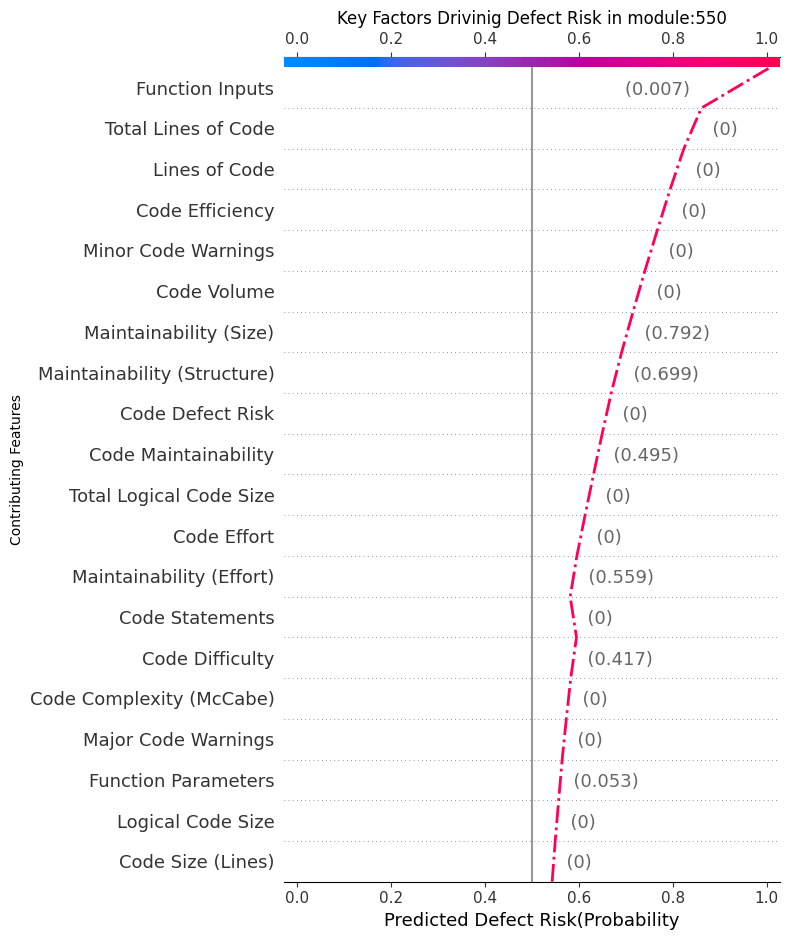

In [30]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib
import json

# Load data and model components
X_scaled = pd.read_pickle("/Users/kiransaud/Desktop/XAI-SHAP/explanations/X_scaled.pkl")
raw = np.load("/Users/kiransaud/Desktop/XAI-SHAP/explanations/shap_values_class1.npy")
rf_model = joblib.load("/Users/kiransaud/Desktop/XAI-SHAP/models/rf_baseline.pkl")

# Calculate SHAP sum for each module to identify high-risk ones
shap_sums = np.sum(raw, axis=1)
modules = pd.DataFrame({
    "Module": X_scaled.index,
    "SHAP_Sum": shap_sums
})
high_risk_modules = modules.sort_values(by="SHAP_Sum", ascending=False).head(1)  # Top 3 modules

# Get indices of high-risk modules
high_risk_indices = high_risk_modules.index.tolist()

# Subset SHAP values and X_scaled for these modules
shap_values_subset = raw[high_risk_indices]
X_subset = X_scaled.iloc[high_risk_indices]

# Map technical feature names to manager-friendly terms

# Rename columns in X_subset for the plot
X_subset.columns = [feature_names_map.get(col, col) for col in X_subset.columns]

# Create SHAP Explanation object
explainer = shap.TreeExplainer(rf_model)
base_value = explainer.expected_value[1]  # Base value for the "buggy" class
shap_explanation = shap.Explanation(values=shap_values_subset, 
                                    base_values=np.ones(len(high_risk_indices)) * base_value, 
                                    data=X_subset, 
                                    feature_names=X_subset.columns)

# Generate SHAP decision plot
plt.figure(figsize=(10, 8))
shap.decision_plot(base_value, shap_values_subset, X_subset, 
                   feature_names=X_subset.columns.tolist(),
                   feature_order="importance",  # Order by SHAP value importance
                #    link="identity",  # Use 'logit' if probabilities are log-odds
                   highlight=[0],  # Highlight the first module in red
                   show=False,)
plt.title(f"Key Factors Drivinig Defect Risk in module:{X_subset.index[0]}")
plt.xlabel("Predicted Defect Risk(Probability")
plt.ylabel("Contributing Features")
plt.tight_layout()
plt.show()
# plt.savefig("/Users/kiransaud/Desktop/XAI-SHAP/explanations/decision_plot_high_risk.png")
plt.close()


In [ ]:
import shap, pandas as pd, numpy as np, joblib, json, os

# ------------------------------------------------------------------
# 0.  Paths and artefacts you already saved
# ------------------------------------------------------------------
ART = "/Users/kiransaud/Desktop/XAI-SHAP/"

X_scaled   = pd.read_pickle(f"{ART}explanations/X_scaled.pkl")
shap_vals  = np.load        (f"{ART}explanations/shap_values_class1.npy")
rf_model   = joblib.load    (f"{ART}models/rf_baseline.pkl")
background = pd.read_pickle (f"{ART}models/background.pkl")

# ------------------------------------------------------------------
# 1.  Build explainer just to get base value
# ------------------------------------------------------------------
explainer   = shap.TreeExplainer(rf_model,
                                 background,
                                 model_output="probability")
base_value  = explainer.expected_value[1]   # baseline buggy probability

# ------------------------------------------------------------------
# 2.  Pick the “most interesting” module (largest |SHAP| sum)
# ------------------------------------------------------------------
impact  = np.abs(shap_vals).sum(axis=1)
top_idx = int(impact.argmax())

# ------------------------------------------------------------------
# 3.  Rename columns for readability
# ------------------------------------------------------------------
# copy *one* row so we don’t change the full DataFrame
X_subset = X_scaled.iloc[[top_idx]].copy()
X_subset.columns = [feature_names_map.get(c, c) for c in X_subset.columns]

# ------------------------------------------------------------------
# 4.  Extract SHAP values for that row (same order as columns)
# ------------------------------------------------------------------
row_sv = shap_vals[top_idx]                # numpy array, shape = (#features,)

# ------------------------------------------------------------------
# 5.  Create horizontal force plot (default orientation)
# ------------------------------------------------------------------
shap.initjs()  # injects JS only once per Python session

force_obj = shap.force_plot(
    base_value,
    row_sv,
    X_subset.iloc[0],            # feature values for that module
    feature_names = X_subset.columns,
    matplotlib     = False       # interactive JS plot
)

out_html = f"{ART}explanations/force_plot_horizontal_module_{top_idx}.html"
shap.save_html(out_html, force_obj)
print(f"✅ Saved horizontal force plot → {out_html}")


✅ Saved horizontal force plot → /Users/kiransaud/Desktop/XAI-SHAP/explanations/force_plot_horizontal_module_3993.html


INTERPRETATION GUIDE:
    
    • Red bars push prediction 
      toward "BUGGY"
    • Blue bars push prediction 
      toward "CLEAN"
    • Longer bars = stronger 
      influence
    • Feature values shown 
      in parentheses

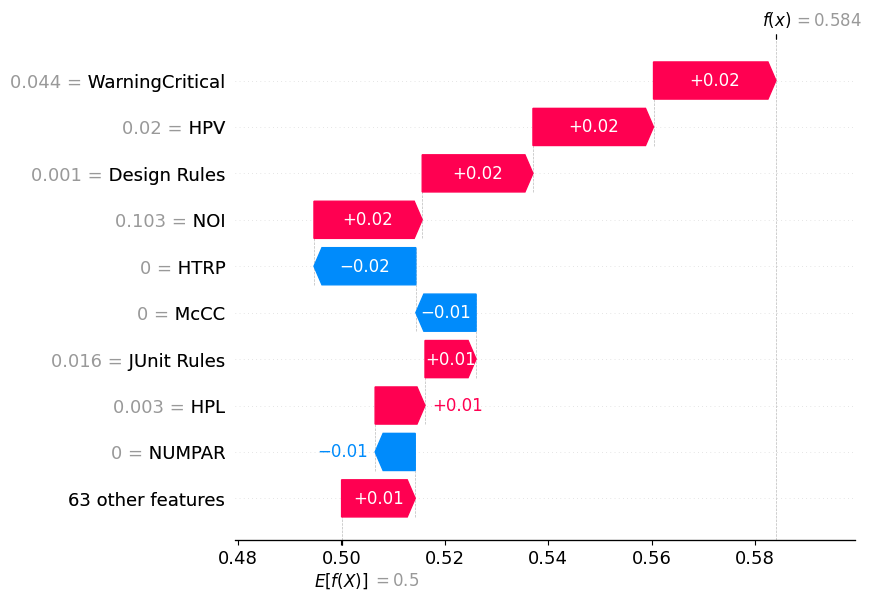

In [ ]:

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import os
import json

# Load and rename columns
X_scaled = pd.read_pickle("/Users/kiransaud/Desktop/XAI-SHAP/explanations/X_scaled.pkl")

feature_names_map = {
}
X_scaled = X_scaled.rename(columns=feature_names_map)

# Ensure output directory exists
os.makedirs("static/manager", exist_ok=True)

# Load data
shap_values_class1 = np.load("/Users/kiransaud/Desktop/XAI-SHAP/explanations/shap_values_class1.npy")
rf_model = joblib.load("/Users/kiransaud/Desktop/XAI-SHAP/models/rf_baseline.pkl")

# Load threshold from file
with open("/Users/kiransaud/Desktop/XAI-SHAP/models/threshold.json", "r") as f:
    threshold = json.load(f).get("threshold", 0.215)

# Create TreeExplainer
explainer = shap.TreeExplainer(rf_model)
base_value = explainer.expected_value[1]  # for class 1 = buggy

# Select instance
i = 3990
instance_data = X_scaled.iloc[i]
instance_shap = shap_values_class1[i]
prediction_proba = rf_model.predict_proba(X_scaled.iloc[[i]])[0]
predicted_class = int(prediction_proba[1] >= threshold)

# SHAP waterfall plot
shap.initjs()
exp = shap.Explanation(
    values=instance_shap,
    base_values=base_value,
    data=instance_data.values,
    feature_names=X_scaled.columns
)
shap.plots.waterfall(exp, max_display=10)

# Dashboard function

def create_plotly_summary_dashboard(instance_shap, instance_data, base_value, feature_names, 
                                    prediction_proba, predicted_class, instance_id, threshold):
    feature_importance = list(zip(feature_names, instance_shap, instance_data.values))
    feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    top_10 = feature_importance[:10]

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Waterfall Flow', 'Feature Importance', 'Prediction Summary', 'Mathematical Breakdown'),
        specs=[[{"colspan": 2}, None], [{"type": "bar"}, {"type": "table"}]],
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )

    top_features = top_10[:8]
    shap_vals = [x[1] for x in top_features]
    feat_names = [f"{x[0][:20]}..." if len(x[0]) > 20 else x[0] for x in top_features]
    feat_values = [x[2] for x in top_features]

    x_labels = ['Base'] + [f'{name}<br>({val:.3f})' for name, val in zip(feat_names, feat_values)] + ['Final']
    y_values = [base_value] + shap_vals + [sum(shap_vals)]
    measure_types = ['absolute'] + ['relative'] * len(shap_vals) + ['total']

    fig.add_trace(go.Waterfall(
        orientation="v",
        measure=measure_types,
        x=x_labels,
        y=y_values,
        text=[f"{val:.3f}" for val in y_values],
        textposition="auto",
        connector={"line": {"color": "gray", "dash": "dot"}},
        decreasing={"marker": {"color": "rgba(0, 123, 255, 0.8)"}},
        increasing={"marker": {"color": "rgba(220, 53, 69, 0.8)"}},
        totals={"marker": {"color": "rgba(255, 136, 0, 0.8)"}},
    ), row=1, col=1)

    feat_names_bar = [x[0][:15] + "..." if len(x[0]) > 15 else x[0] for x in top_10]
    shap_vals_bar = [x[1] for x in top_10]
    colors_bar = ['rgba(220, 53, 69, 0.8)' if x > 0 else 'rgba(0, 123, 255, 0.8)' for x in shap_vals_bar]

    fig.add_trace(go.Bar(
        x=shap_vals_bar,
        y=feat_names_bar,
        orientation='h',
        marker_color=colors_bar,
        text=[f"{val:+.4f}" for val in shap_vals_bar],
        textposition='auto'
    ), row=2, col=1)

    final_pred = base_value + sum(instance_shap)
    table_data = [
        ["Base Prediction", f"{base_value:.4f}"],
        ["Total SHAP Impact", f"{sum(instance_shap):+.4f}"],
        ["Final Prediction", f"{final_pred:.4f}"],
        ["Classification", "🐛 BUGGY" if final_pred >= threshold else "✅ CLEAN"],
        ["Confidence", f"{prediction_proba[predicted_class]:.1%}"],
        ["Bug Probability", f"{prediction_proba[1]:.1%}"],
        ["Clean Probability", f"{prediction_proba[0]:.1%}"]
    ]

    fig.add_trace(go.Table(
        header=dict(values=['Metric', 'Value'], fill_color='lightblue', align='left'),
        cells=dict(values=[[row[0] for row in table_data], [row[1] for row in table_data]],
                  fill_color='white', align='left')
    ), row=2, col=2)

    fig.update_layout(
        height=800,
        title_text=f"<b>SHAP Analysis Dashboard - Instance #{i}</b>",
        title_x=0.5,
        showlegend=False
    )

    fig.add_shape(type="line", x0=0, x1=1, y0=threshold, y1=threshold, xref="x domain", yref="y",
                  line=dict(color="red", width=3, dash="dash"), row=1, col=1)
    fig.add_annotation(x=0.8, y=threshold, text=f"Bug Threshold ({threshold:.2f})", showarrow=True,
                       arrowhead=2, arrowcolor="red", arrowwidth=2,
                       bgcolor="white", bordercolor="red", borderwidth=1,
                       xref="x domain", yref="y", row=1, col=1)

    fig.update_xaxes(title_text="Step", row=1, col=1)
    fig.update_yaxes(title_text="Prediction Value", row=1, col=1)
    fig.update_xaxes(title_text="SHAP Value", row=2, col=1)
    fig.update_yaxes(title_text="Features", row=2, col=1)

    return fig

# Render dashboard
dashboard_fig = create_plotly_summary_dashboard(
    instance_shap,
    instance_data,
    base_value,
    X_scaled.columns,
    prediction_proba,
    predicted_class,
    i,
    threshold
)
dashboard_fig.show()



In [25]:
import joblib
import pandas as pd
import numpy as np

# Load model and data
rf_model = joblib.load("models/rf_baseline.pkl")
scaler = joblib.load("/Users/kiransaud/Desktop/XAI-SHAP/models/scaler.pkl")
# X = pd.read_pickle("X_raw_or_scaled.pkl")  # If raw, scale below

# Scale if necessary
X_scaled = scaler.transform(X)

# Predict probabilities for class 1 (buggy)
buggy_probs = rf_model.predict_proba(X_scaled)[:, 1]

# Get average probability
avg_buggy_prob = np.mean(buggy_probs)
print(f"🐞 On average, the model predicts a bug probability of {avg_buggy_prob * 100:.2f}%")


🐞 On average, the model predicts a bug probability of 48.51%
